In [2]:
import os
import glob
import librosa
from tqdm import tqdm
import joblib
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


In [8]:
mfcc_dict = {}
sound_path = os.path.join("..", "data", "sounds")
max_sound_length = 173

for file in tqdm(glob.glob(os.path.join(sound_path, "*.wav"))):
    sound_id = file[len(sound_path + "/"):-len(".wav")]
    mfcc = librosa.feature.mfcc(*librosa.load(file))
    mfcc = librosa.util.fix_length(mfcc, max_sound_length)
    mfcc_dict[int(sound_id)] = mfcc

100%|██████████████████████████████████████| 3670/3670 [09:04<00:00,  6.74it/s]


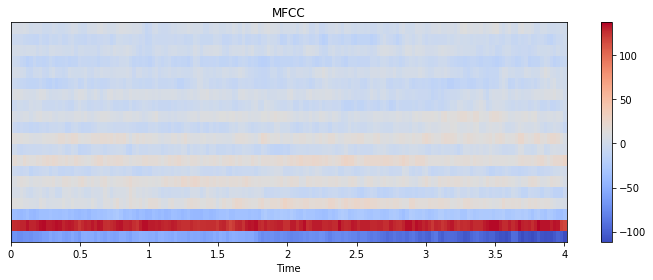

In [15]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_dict[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [17]:
mfcc_filepath = os.path.join("..", "data", "mfcc", "mfcc_dict.z")
joblib.dump(mfcc_dict, mfcc_filepath)

['..\\data\\mfcc\\mfcc_dict.z']

In [18]:
mfcc_filepath = os.path.join("..", "data", "mfcc", "mfcc_dict.z")
mfcc_dict = joblib.load(mfcc_filepath)

In [99]:
label_dir = os.path.join("..", "data", "labels")
df_labels = pd.read_csv(os.path.join(label_dir, "train_short.csv"))
df_labels[:5]

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [101]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

train_mfcc_2D = [mfcc_dict[mfcc_id] for mfcc_id in df_labels.loc[:, "ID"]]
train_mfcc_2D = np.stack(train_mfcc_2D)
train_mfcc_1D = train_mfcc_2D.reshape(136, -1)
print(train_mfcc_2D.shape)
print(train_mfcc_1D.shape)
labels = df_labels.loc[:, "Class"]

label_enc = LabelEncoder()
int_labels = label_enc.fit_transform(labels)

one_hot_enc = OneHotEncoder()
y = one_hot_enc.fit_transform(int_labels.reshape(-1, 1))
y

(136, 20, 173)
(136, 3460)


<136x10 sparse matrix of type '<class 'numpy.float64'>'
	with 136 stored elements in Compressed Sparse Row format>

In [130]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

num_classes = 10

mlp = keras.models.Sequential()
mlp.add(Dense(64, input_shape=(train_mfcc_1D.shape[1],), activation="relu"))
mlp.add(BatchNormalization())
mlp.add(Dense(64, activation="relu"))
mlp.add(BatchNormalization())
mlp.add(Dense(num_classes, activation="softmax"))

In [124]:
# test data TODO: use a function <.<

df_labels = pd.read_csv(os.path.join(label_dir, "test.csv"))
test_mfcc_2D = [mfcc_dict[mfcc_id] for mfcc_id in df_labels.loc[:, "ID"]]
test_mfcc_2D = np.stack(test_mfcc_2D)
test_mfcc_1D = test_mfcc_2D.reshape(test_mfcc_2D.shape[0], -1)
test_labels = df_labels.loc[:, "Class"]

test_label_enc = LabelEncoder()
test_int_labels = test_label_enc.fit_transform(test_labels)

test_one_hot_enc = OneHotEncoder()
test_y = test_one_hot_enc.fit_transform(test_int_labels.reshape(-1, 1))
test_y

<33x10 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [131]:
mlp.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print(mlp.metrics_names)
for epoch in range(10):
    mlp.fit(train_mfcc_1D, y, epochs=10, batch_size=32, verbose=0)
    test_acc = mlp.evaluate(test_mfcc_1D, test_y, verbose=0)[1]
    train_acc = mlp.evaluate(train_mfcc_1D, y, verbose=0)[1]
    print(f"epoch {epoch + 1}: test_acc={test_acc:.3}, "
          f"train_acc={train_acc:.2}")

['loss', 'acc']
epoch 1: test_acc=0.515, train_acc=0.85
epoch 2: test_acc=0.273, train_acc=0.86
epoch 3: test_acc=0.545, train_acc=0.98
epoch 4: test_acc=0.424, train_acc=0.94
epoch 5: test_acc=0.485, train_acc=1.0
epoch 6: test_acc=0.333, train_acc=0.95
epoch 7: test_acc=0.333, train_acc=0.96
epoch 8: test_acc=0.394, train_acc=0.94
epoch 9: test_acc=0.424, train_acc=0.81
epoch 10: test_acc=0.424, train_acc=0.96
